## Visualization

Visualization is successfully used to communicate both abstract and concrete ideas. 
The application of visualization falls into two phases. 
First, the exploration phase where the analysts will use graphics that are mostly incompatible for presentation purposes but make it easy to find interesting and important features of the data. 
The amount of interaction needed during exploration is very high and includes filtering, zooming and rearranging data. 
After key findings are discovered in the data, 
these findings must be presented in a way suitable for presentation for a larger audience. 
In this second phase it is important that the analyst can manipulate the presentation to clearly highlight the findings.

### arulesViz

This R package is a simple unified interface for many kinds of existing plots to visualize data. 
**`arulesViz`** package will automatically load other needed packages like `arules` for handling and mining association rules.
In this notebook we load the “Groceries” data set which is included in arules.

In [1]:
# install.packages("arulesViz",repo="http://cran.stat.ucla.edu/")
library("arulesViz")

Loading required package: arules
Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: grid


In [2]:
data("Groceries")

The Groceries data set contains sales data from a local grocery store with 9835 transactions and 169 items (product groups). The summary shows some basic statistics of the data set. For example, the summary tells us that the data set is rather sparse with a density just above 2.6%, that “whole milk” is the most popular item and that the average transaction contains less than 5 items.


In [3]:
summary(Groceries)

transactions as itemMatrix in sparse format with
 9835 rows (elements/itemsets/transactions) and
 169 columns (items) and a density of 0.02609146 

most frequent items:
      whole milk other vegetables       rolls/buns             soda 
            2513             1903             1809             1715 
          yogurt          (Other) 
            1372            34055 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2159 1643 1299 1005  855  645  545  438  350  246  182  117   78   77   55   46 
  17   18   19   20   21   22   23   24   26   27   28   29   32 
  29   14   14    9   11    4    6    1    1    1    1    3    1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   4.409   6.000  32.000 

includes extended item information - examples:
       labels  level2           level1
1 frankfurter sausage meat and sausage
2     sausage sausage meat and sausage
3  live

#### We can generate association rules with a support of 0.001 and confidence of 0.5 using the Apriori algorithm.

In [4]:
rules <- apriori(Groceries, parameter=list(support=0.001, confidence=0.5))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5   0.001      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 9 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.01s].
sorting and recoding items ... [157 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 5 6 done [0.02s].
writing ... [5668 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].


The result is a set of 5668 association rules. The top three rules with respect to the lift measure are:

In [5]:
inspect(head(sort(rules, by ="lift"),3))

    lhs                             rhs              support     confidence
[1] {Instant food products,soda} => {hamburger meat} 0.001220132 0.6315789 
[2] {soda,popcorn}               => {salty snack}    0.001220132 0.6315789 
[3] {flour,baking powder}        => {sugar}          0.001016777 0.5555556 
    lift     count
[1] 18.99565 12   
[2] 16.69779 12   
[3] 16.40807 10   


It is not feasible to go through all the 5668 rules manually. Instead, we will explore the rules using different visualization techniques implemented in `arulesViz`. All implemented visualization techniques share the following interface:

$$ plot(x, method = NULL, measure = "support", shading = "lift", interactive = FALSE, data = NULL, control = NULL, ...) $$

where **`x`** is the set of rules to be visualized, **method** is the visualization method, **measure** and **shading** contain the interest measures used by the plot, **interactive** indicates if we want to interactively explore or just present the rules, **data** can contain the transaction dataset used to mine the rules (only necessary for some methods) and **control** is a list with further control arguments to customize the plot.

### scatter plot

scatter plot will have `support` and `confidence` on the axes. In addition, `lift` is used to color (gray level) the points.

Warning message in plot.rules(rules, method = "scatter", measure = "support", shading = "lift", :
“The parameter interactive is deprecated. Use engine='interactive' instead.”To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


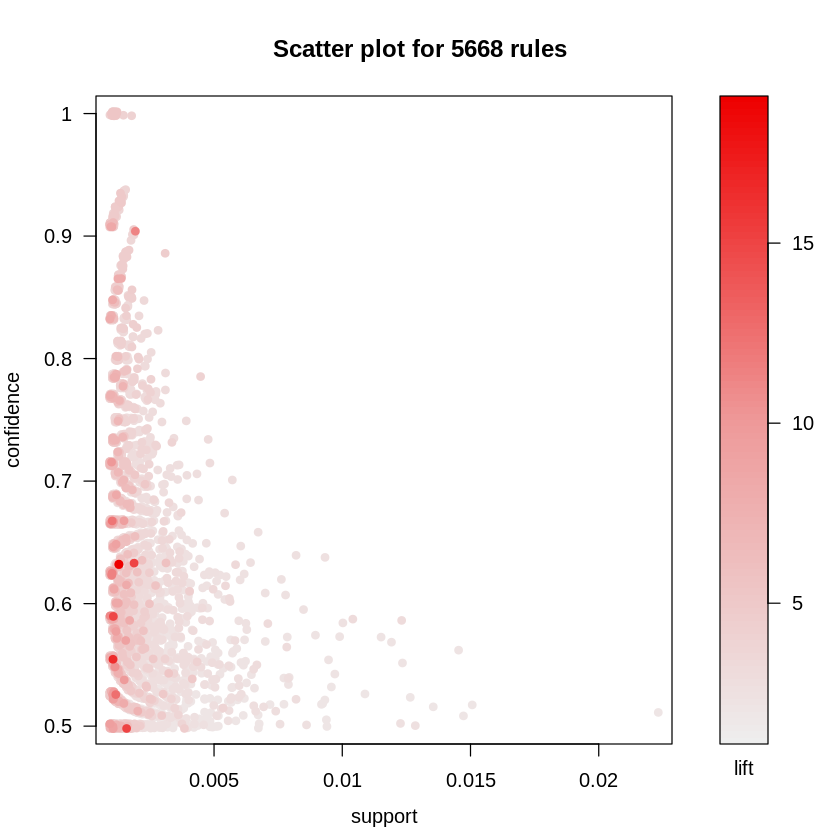

In [6]:
plot(rules, method = "scatter", measure = "support", shading = "lift", interactive = FALSE, data = Groceries,)

The plot suggests rules with high confidence typically have a relatively low support. Customize the plot by switching lift and confidence:

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


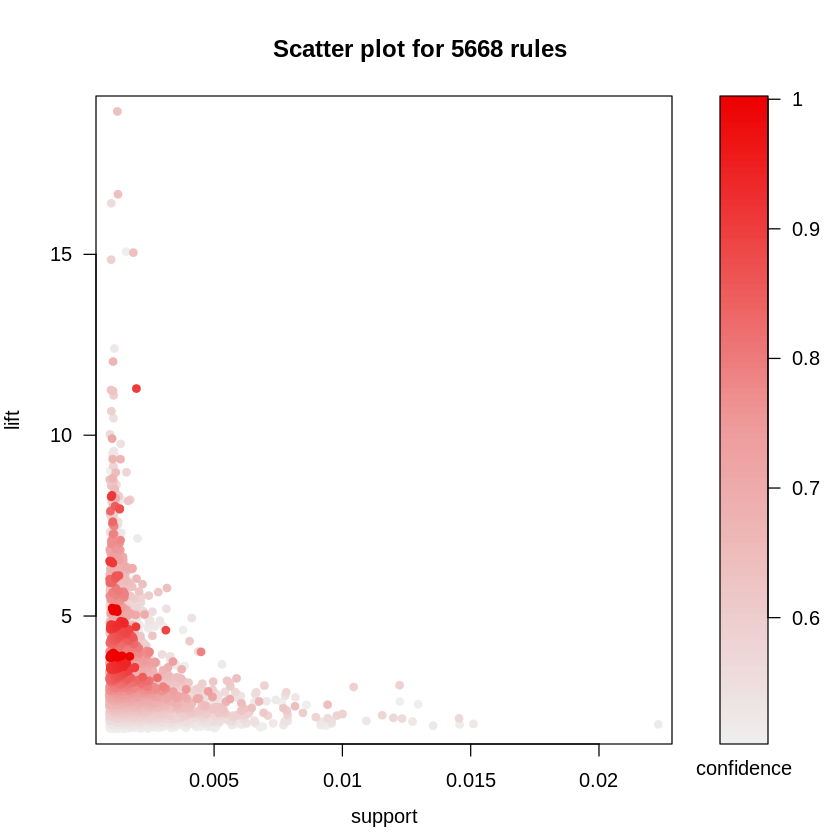

In [7]:
plot(rules, measure=c("support", "lift"), shading="confidence")

It is easy to identify all rules with high lift in above plot. The next cell renders a special version of a scatter plot called a Two-key plot. Here support and confidence are used for the x and y-axes and the color of the points is used to indicate “order,” i.e., the number of items contained in the rule. 

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


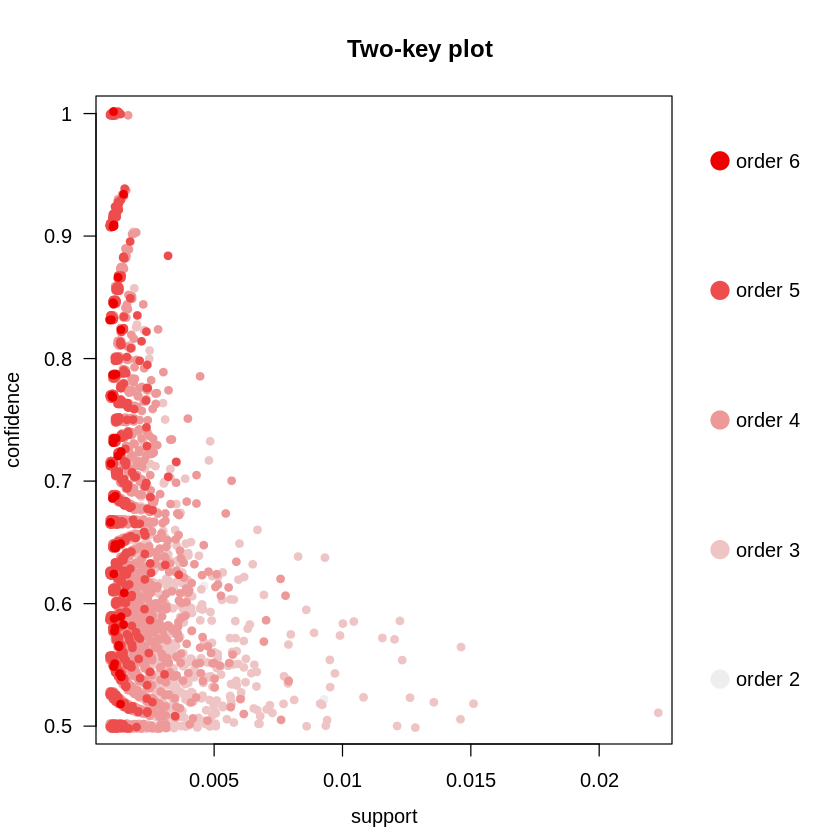

In [8]:
plot(rules, shading="order", control=list(main = "Two-key plot"))

From the plot it is clear that order and support have a very strong inverse relationship, which is a known fact for association rules.

### Matrix-based visualizations

Matrix-based visualization techniques that organize the antecedent and consequent itemsets on the x and y-axes, respectively. 
A selected interest measure is displayed at the intersection of the antecedent and consequent of a given rule. 
If no rule is available for a antecedent/consequent combination the intersection area is left blank.

The visualized matrix is constructed as follows. 
We start with the set of association rules. 

$$ R = {\{<a_1, c_1, m_1>, . . .<a_i, c_i, m_i>, . . .<a_n, c_n, m_n>\}} $$

where $a_i$ is the antecedent, $c_i$ is the consequent and $m_i$ is the selected interest measure for the $i_{th}$ rule for i = 1, . . . , n. 
The set of `K` unique antecedents and L unique consequents are identified. 
Create a **L × K** matrix **M** with one column for each unique antecedent and one row for each unique consequent. 
Finally, populate the matrix by setting $M_{lk}$ = $m_i$ for i = 1, . . . , n and _l_ and _k_ corresponding to the position of $a_i$ and $c_i$ in the matrix. 
`M` will contain many empty cells since many potential association rules will not meet the required minimum thresholds on support and confidence.

In [9]:
subrules <- rules[quality(rules)$confidence > 0.8]
subrules

set of 371 rules 

Itemsets in Antecedent (LHS)
  [1] "{liquor,red/blush wine}"                                                   
  [2] "{curd,cereals}"                                                            
  [3] "{yogurt,cereals}"                                                          
  [4] "{butter,jam}"                                                              
  [5] "{soups,bottled beer}"                                                      
  [6] "{napkins,house keeping products}"                                          
  [7] "{whipped/sour cream,house keeping products}"                               
  [8] "{pastry,sweet spreads}"                                                    
  [9] "{rice,sugar}"                                                              
 [10] "{butter,rice}"                                                             
 [11] "{domestic eggs,rice}"                                                      
 [12] "{rice,bottled water}"                              

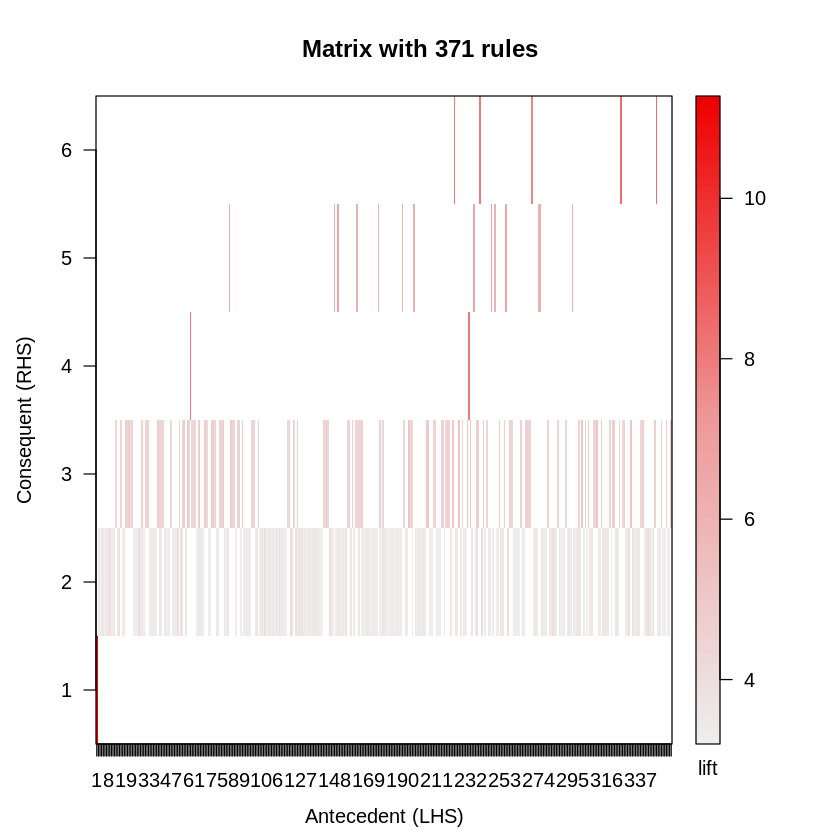

In [10]:
plot(subrules, method="matrix", measure="lift", control=list(reorder="none"))

The labels are displayed properly as the plot can only accomodate so many. Complete itemsets are printed for look-up. The rows and columns in the matrix can be reordered such that rules with similar values of the interest measure are presented closer together. This removes some of the fragmentation in the matrix display and therefore makes it easier to see structure.

There are four options for ordering the rules: "none", "measure", "support/confidence", or "similarity."
The docs say "The default reordering average measure (typically lift) pushes the rules with the highest lift value to the top-left corner of the plot." 

The option "support/confidence" orders the RHS by average support and the LHS by average confidence. The option "similarity" computes the dissimilarity of the LHS using the jaccard method and orders by that, while ordering the RHS by the specified measure.

You can experiment with different orderings to see what they do.

Itemsets in Antecedent (LHS)
  [1] "{liquor,red/blush wine}"                                                   
  [2] "{citrus fruit,other vegetables,soda,fruit/vegetable juice}"                
  [3] "{tropical fruit,other vegetables,whole milk,yogurt,oil}"                   
  [4] "{citrus fruit,grapes,fruit/vegetable juice}"                               
  [5] "{other vegetables,whole milk,yogurt,rice}"                                 
  [6] "{tropical fruit,other vegetables,whole milk,oil}"                          
  [7] "{ham,pip fruit,other vegetables,yogurt}"                                   
  [8] "{beef,citrus fruit,tropical fruit,other vegetables}"                       
  [9] "{tropical fruit,whole milk,butter,sliced cheese}"                          
 [10] "{other vegetables,curd,whipped/sour cream,cream cheese }"                  
 [11] "{tropical fruit,other vegetables,butter,white bread}"                      
 [12] "{sausage,pip fruit,sliced cheese}"                 

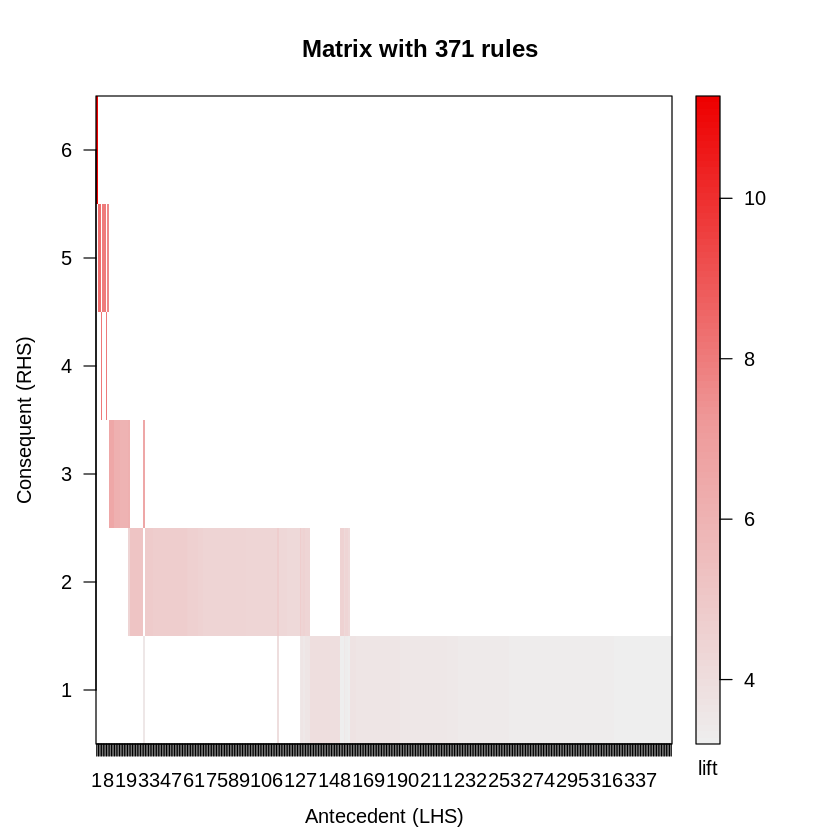

In [11]:
plot(subrules, method="matrix", measure="lift", control=list(reorder="measure"))

Using reorder="measure", that is, ordering by lift, we see the emergence of two large blocks of rules with two different consequents and then smaller blocks for the rest. 

### Grouped matrix-based visualization

Matrix-based visualization is limited in the number of rules it can visualize effectively since large sets of rules typically also have large sets of unique antecedents/consequents. This matrix-based visualization uses grouping of rules via clustering to handle a larger number of rules.  Grouped rules are presented as an aggregate in the matrix. 

A direct approach to cluster itemsets is to define a distance metric between two itemsets $X_i$ and $X_j$ . A good choice is the Jaccard distance defined as

$$ {d_{Jaccard}}(X_i, X_j) = 1 −\frac{|X_i ∩ X_j |}{|X_i ∪ X_j|} $$

The distance simply is the number of items that $X_i$ and $X_j$ have in common divided by the number of unique items in both sets. For a set of m rules we can calculate the $\frac{m(m − 1)}{2}$ distances and use them as the input for clustering. However, using clustering on the itemsets directly has several problems. First of all, datasets typically mined for association rules are high-dimensional, i.e., contain a large number of different items. This high dimensionality is carried over to the mined rules and leads to "curse of dimensionality" where, due to the exponentially increasing volume, distance functions lose their usefulness. The situation is getting worse since minimum support used in association rule mining and relatively short rules result in extremely sparse data. This problem is addressed in this visualization. For more reading [click here and go to page 13](https://cran.r-project.org/web/packages/arulesViz/vignettes/arulesViz.pdf)

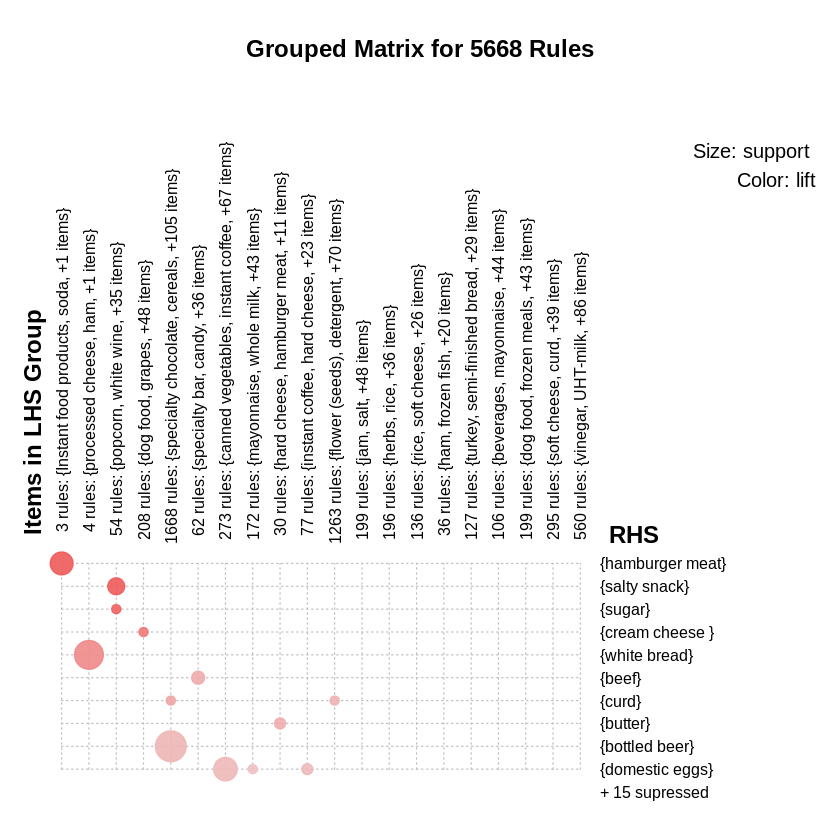

In [12]:
plot(rules, method="grouped")

In the grouped matrix plot, antecedent groups are columns and consequents are rows. The color of the balloons represent the aggregated interest measure in the group with a certain consequent and the size of the balloon shows the aggregated support. The default aggregation function is the median value in the group. The number of antecedents and the most important (frequent) items in the group are displayed as the labels for the columns. Furthermore, the columns and rows in the plot are reordered such that the aggregated interest measure is decreasing from top down and from left to right, placing the most interesting group in the top left corner. 


In above visualization the group of most interesting rules according to lift which is the default measure are shown in the top-left corner of the plot. There are 3 rules which contain “Instant food products” and up to 2 other items in the antecedent and
the consequent is "hamburger meat".

To increase the number of groups change k which defaults to 20.

### Graph-based visualizations

Graph-based visualizations visualize association rules using vertices and edges where vertices typically represent items or itemsets and edges indicate relationships in rules. Interest measures are typically added to the plot as labels on the edges or by color or width of the arrows displaying the edges. Graph-based visualization offers a very clear representation of rules but they tend to easily become cluttered and thus are only viable for very small sets of rules. For the following plots we select the 10 rules with the highest lift.

In [13]:
subrules2 <- head(sort(rules, by="lift"), 10)

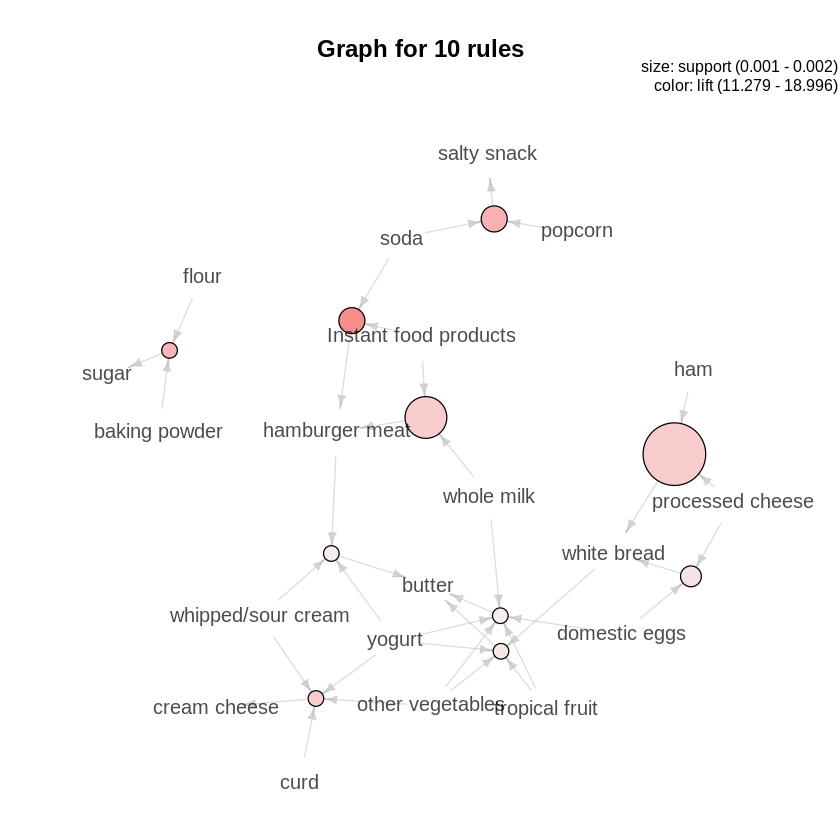

In [14]:
ig = plot(subrules2, method="graph")
# equivalent to ig <- plot( subrules2, method="graph", control=list(type="items") )

The above representation focuses on how the rules are composed of individual items and shows which rules share items.

To explore large sets of rules with graphs, advanced interactive features like zooming, filtering, grouping and coloring nodes are needed. Such features are available in interactive visualization and exploration platforms for networks and graphs like `Gephi`. `arulesViz` graphs for sets of association rules can be exported in the GraphML format or as a Graphviz dot-file to be explored in tools like [Gephi](https://gephi.org/). For example the 1000 rules with the highest lift are exported as..

In [15]:
saveAsGraph(head(sort(rules, by="lift"),1000), file="rules.graphml")

To explore more visuaizations [go to this pdf.](https://cran.r-project.org/web/packages/arulesViz/vignettes/arulesViz.pdf) 

# Save your notebook, then `File > Close and Halt`